In [1]:
# !pip install scikit-learn

In [2]:
import sys
print(sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [3]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from math import sqrt

In [5]:
print("Tensorflow version: ", tf.VERSION) # 1.13.1
print("Keras version: ", tf.keras.__version__) # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.13.1
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  True


# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [6]:
filename = 'input_noise'

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

predict_only = True
predict_test_only = False

pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))


In [7]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)
            
        model.add(Dropout(0.2, noise_shape=noiseShape,
                          input_shape=inputShape)) # black
        model.add(Lambda(lambda x: 1 - x)) # 0 to 1, 1 to 0
        model.add(Dropout(0.1, noise_shape=noiseShape)) # white
        model.add(Lambda(lambda x: 1 - x))
        model.add(Activation("relu"))
           
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, name='learned_representation'))
        model.add(Activation("relu"))
        model.add(BatchNormalization(name='normalized_representation'))
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [8]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [9]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1

def _parse_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['norm_year']

def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

train_dataset = create_dataset(path_train_tfrecord)
test_dataset =  create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [10]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2],
)

for images,labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())
    
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Logits:  [[-0.05558252]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
______________________________________________________________

In [11]:
model.compile(optimizer='RMSprop', 
              loss='mean_squared_error')

Instructions for updating:
Use tf.cast instead.


In [12]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [13]:
def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [14]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [15]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

predictions = [x[0] for x in predictions]
# predictions

In [16]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

In [17]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [18]:
df = pd.DataFrame(zip(ids, true_year, predictions), columns=['ID', 'true_year', 'prediction'])
# df

In [19]:
df.corr()

,true_year,prediction
true_year,1.000000,0.943736
prediction,0.943736,1.000000


In [20]:
corr_year = df['true_year'].corr(df['prediction'])
r2_text = format(corr_year**2, '.3f')
r2_text = '$r^2 = ' + r2_text + '$'

if predict_test_only: 
    r2_text += '\n(Test dataset only)'
    
r2_text

'$r^2 = 0.891$'

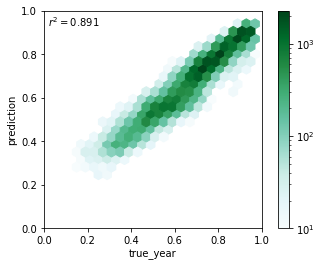

In [21]:
ax = df.plot.hexbin(x='true_year',y='prediction',
                    extent=(-0.03,1.01,-0.03,1.01), xlim=(0,1), ylim=(0,1), 
                    sharex=False, gridsize=26,
                    bins='log', mincnt=10,
                   )
ax.set_facecolor('w')
ax.set_aspect('equal')
ax.text(0.02,0.98,r2_text, verticalalignment='top')
fig = ax.get_figure()

if predict_test_only: 
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".pdf")
# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".png")

In [22]:
# !cp /data/{filename}* .

In [23]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

layer_name = 'normalized_representation'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
intermediate_output = intermediate_layer_model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

intermediate_output.shape

(50540, 64)

In [24]:
X = pd.DataFrame(intermediate_output)
y_pred = df['prediction']
y_true = df['true_year']

In [25]:
print(X.shape, y_pred.shape)

(50540, 64) (50540,)


In [26]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,...,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,0.020839,-0.024505,0.012379,-0.025510,0.006238,0.022566,0.008364,0.002686,0.023153,0.005607,...,0.031705,-0.012075,0.019179,0.026192,0.040653,0.050561,0.007183,0.018600,0.037966,-0.009191
std,0.123312,0.150412,0.162176,0.130364,0.105160,0.103100,0.123142,0.080311,0.092586,0.098068,...,0.131762,0.125964,0.139509,0.118588,0.093751,0.144906,0.110065,0.111835,0.107644,0.131822
min,-0.291851,-0.252000,-0.351769,-0.320047,-0.079285,-0.192977,-0.223287,-0.080755,-0.330177,-0.251568,...,-0.048243,-0.093970,-0.123750,-0.119186,-0.097222,-0.325675,-3.270901,-0.068048,-0.246225,-0.161433
25%,-0.048196,-0.195403,-0.089282,-0.105002,-0.079285,-0.048529,-0.087933,-0.077326,-0.034912,-0.069140,...,-0.048243,-0.093970,-0.123750,-0.091004,-0.039223,-0.027934,-0.080299,-0.068048,-0.021542,-0.161208
50%,0.042384,0.029341,-0.007201,0.000890,-0.040113,0.055461,0.009391,-0.015804,0.026579,0.006171,...,-0.048243,-0.093970,0.017247,0.033480,0.048009,0.023748,0.024294,-0.025816,0.062744,-0.010092
75%,0.112337,0.095229,0.100220,0.073314,0.066383,0.104221,0.101100,0.052286,0.127944,0.069799,...,0.124581,0.066457,0.107800,0.104395,0.118811,0.093001,0.104016,0.066213,0.118183,0.090393
max,0.445732,0.422182,1.487274,0.298341,0.415100,0.206452,0.400385,0.364542,0.127944,0.208039,...,4.992393,4.244446,2.922475,2.231391,0.481714,3.208491,0.104016,0.620646,0.290536,2.311541


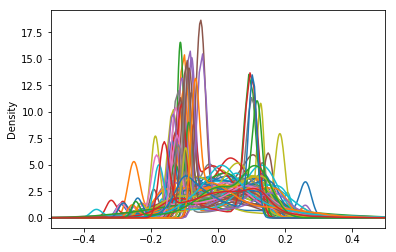

In [27]:
X.plot.kde(legend=False, xlim=(-0.5, 0.5))

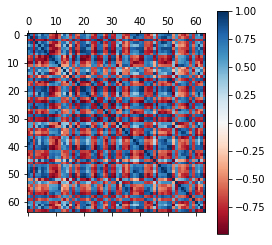

In [28]:
plt.matshow(X.corr(), cmap='RdBu') # no white = high corr
plt.colorbar()
plt.show()

In [29]:
regr = LinearRegression().fit(X, y_pred)
print(regr.score(X, y_pred))
print(format(regr.score(X, y_true), '.3f'), format(corr_year**2, '.3f'))

0.9999999999921961
0.889 0.891


In [30]:
regr.coef_.shape

(64,)

In [31]:
regr.intercept_

0.6956104

In [59]:
ica = FastICA(n_components=7, random_state=1106)
ica.fit(X)
X_ica = pd.DataFrame(ica.transform(X))

In [61]:
regr = LinearRegression().fit(X_ica, X)
print(regr.score(X_ica, X))

0.9571994475257958


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


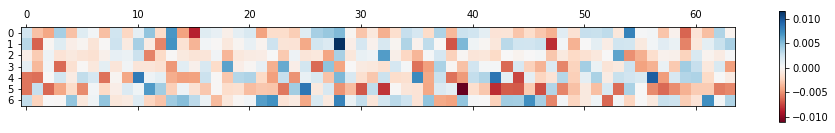

In [33]:
plt.matshow(ica.components_, cmap='RdBu') # more white = less corr
plt.colorbar()
plt.show()

In [34]:
X_ica.describe()
# variance = 1/(n_samples-1)

,0,1,2,3,4,5,6
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
std,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448
min,-0.025381,-0.013498,-0.223952,-0.018970,-0.030479,-0.026639,-0.010336
25%,-0.000511,-0.003531,-0.000777,-0.001900,-0.002216,-0.002657,-0.002602
50%,0.000855,-0.001314,0.000349,0.000501,0.000538,0.000062,-0.001171
75%,0.002303,0.004205,0.001491,0.002615,0.002922,0.002560,0.000867
max,0.040000,0.012907,0.011551,0.015953,0.014063,0.023319,0.030757


In [40]:
X_ica_1std = X_ica*sqrt(50539)
X_ica_1std.describe()

,0,1,2,3,4,5,6
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,-5.705942,-3.034492,-50.346331,-4.264652,-6.852005,-5.988605,-2.323645
25%,-0.114943,-0.793725,-0.174728,-0.427210,-0.498262,-0.597239,-0.584863
50%,0.192313,-0.295376,0.078519,0.112572,0.121013,0.013858,-0.263216
75%,0.517829,0.945226,0.335264,0.587946,0.656815,0.575403,0.194980
max,8.992338,2.901686,2.596841,3.586303,3.161377,5.242418,6.914370


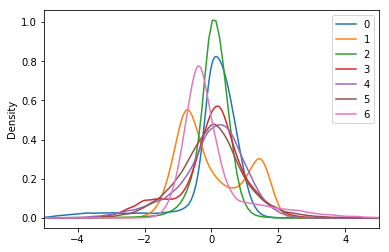

In [41]:
X_ica_1std.plot.kde(xlim=(-5, 5))

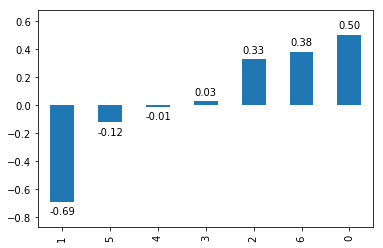

In [37]:
ax = X_ica.corrwith(y_pred).sort_values().plot.bar()
ax.margins(y=0.15) 
bottom, top = ax.get_ylim()
yrange = top - bottom
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 0.02*yrange*(1 if p.get_height()>=0 else -1),
            format(p.get_height(), '.2f'),
            horizontalalignment='center', 
            verticalalignment='bottom' if p.get_height()>=0 else 'top')

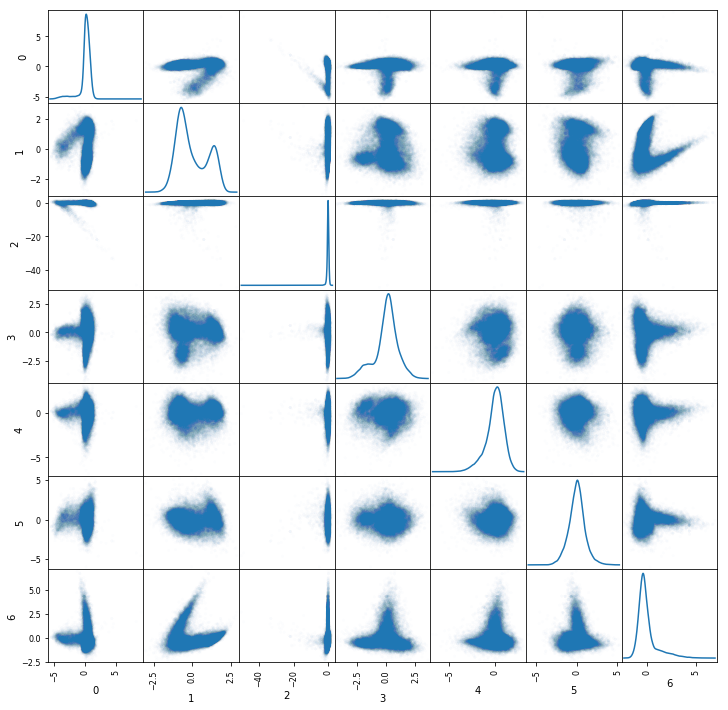

In [42]:
axs = scatter_matrix(X_ica_1std, alpha=0.01, figsize=(12, 12), diagonal='kde')

In [68]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

fps = []
for batch in iter:
    fps.extend(batch[0].numpy())

len(fps), fps[0][:,:,0].shape

(50540, (28, 28))